# Working with sound

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
from IPython.display import Audio
from scipy.io.wavfile import read

## Sampling rate

You've probably already been introduced to the idea of sampling rate and the Nyquist theorem. We're not going to go into the math here, but just review the basic concepts.

Remember that sound is continuous analog information. In order to store a wave of sound information on a computer, it needs to be converted to numbers that can represent this information. 

Each number represents a discrete point along the analog signal. If we want to play back that representation, the computer has to "connect the dots" to recreate the sound wave. 

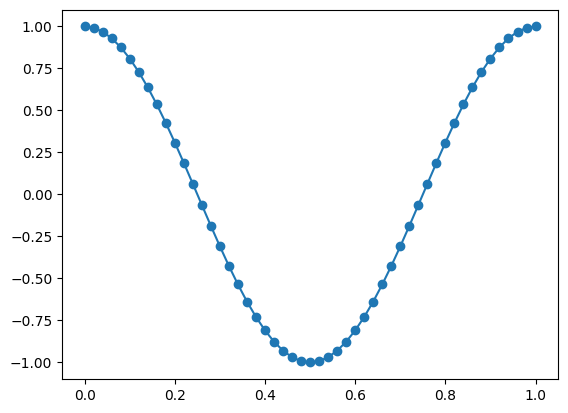

In [ ]:
##how many samples we're going to take in an amount of time
t = np.linspace(0, 1, 51)
s = np.cos(2*np.pi *1 *t) 
plt.plot(t, s, marker = "o")


The extent to which the digitized sound matches the original analog sound depends on the accuracy of the sampled representations. **There are two variables that determine this acccuracy: bit depth and sample rate.**

The standard sampling rate for most types of audio (e.g., CD quality) is 44,100. This means that there are 44,100 samples recorded every second. 

Why do we use this rate?

It first relates to the range of human hearing. 

(which is?)

Humans with "perfect" hearing can hear sounds as low as 20Hz and as high as 20,000 Hz. 

However, by the time most people are in their late 20s they are unlikely to have this range anymore. The high end is the first to go. Here's a depressing (or ear-care-motivating?) graph:

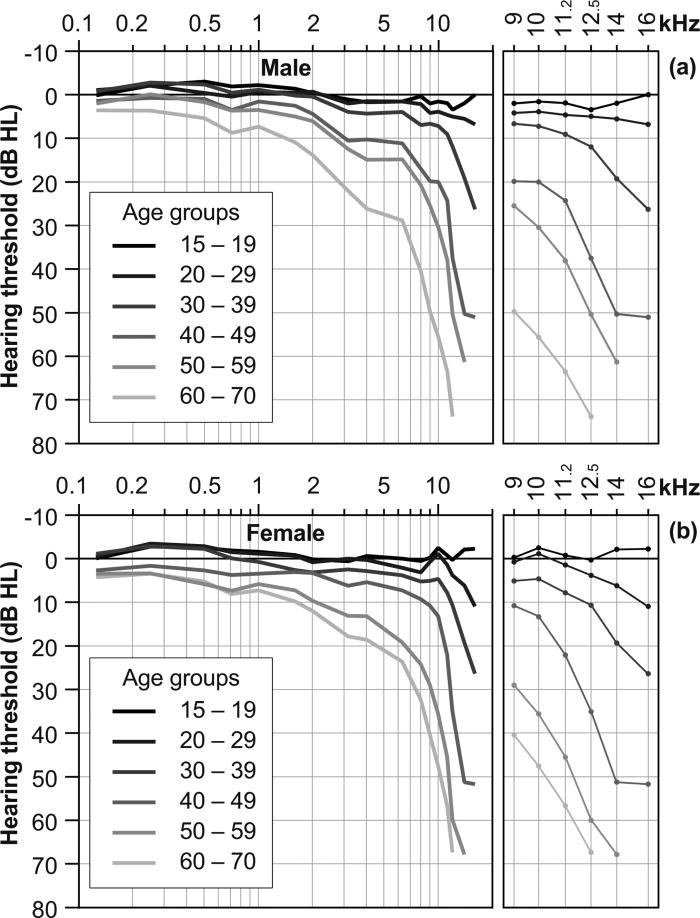

In [3]:
Image(url='https://audiotech2images.s3.us-east-2.amazonaws.com/presbycusis.gif', embed=True, width=400)

Refresher: not all frequencies are heard as equally loud. Some frequencies need a higher volume to be detectable by the ear, while others we are very sensitive to. 

The following graph shows the quietest sounds (technically, the threshold sound intensity) a healthy 20-year-old can hear. For frequencies above 15000 Hz, threshold gets worse very rapidly. 

Aside #1: Notice the dips in sensitivity between 2 and 5KHz? Any idea why this range is important?

In [4]:
Image(url="https://audiotech2images.s3.us-east-2.amazonaws.com/human_hearing.png", width=700)

Back to sampling rate!  

In order to capture a sound signal (as faithfully as possible), what is the slowest sampling rate we can use?

To be able to accurately capture a frequency we need to have a sample rate that's **at least twice the fastest frequency** otherwise we get aliasing (more on this later). This minimum sample rate is referred to as the *Nyquist frequency*.

We don't want to cut off frequencies that are in the normal range of human hearing, the default sampling rate is a bit more than double of the conservative upper-limit of human hearing.

Aside #2: Anyone know why we don't just sample at 40,000? 

One reason has to do with compatibility with video recording. 44,100 samples/s can fit digital audio samples into an analog video channel running 25 or 30 FPS.

However, for that we'd only need 40,050 samples/s.

It has to do with leaving space for something called a *transition band* or a *skirt* when attenuating frequencies over the 20k limit, we want to avoid a sharp "cutoff" and instead offer a smooth gradual decrease. (More on this later).

Of course, there are other sampling rates possible. For instance, 48kHz is the standard for DVD quality. Some people choose to record at 96kHz (e.g., standard for HD DVD and Blue Ray).

## Aliasing
Recap: the sample rate needs to be frequent enough to capture the amplitude changes of extremely fast moving frequencies. So we set our sampling rate to be roughly double the frequency of the maximum frequency we are capable of hearing.

Say we're using a sampling rate of 44,100.  What frequencies might we record that would be problematic according to the Nyquist theorem?

Any frequency content *above* the Nyquist frequency (defined as half the sample rate), will create artifacts. Let's look at an example

What does this plot demonstrate?

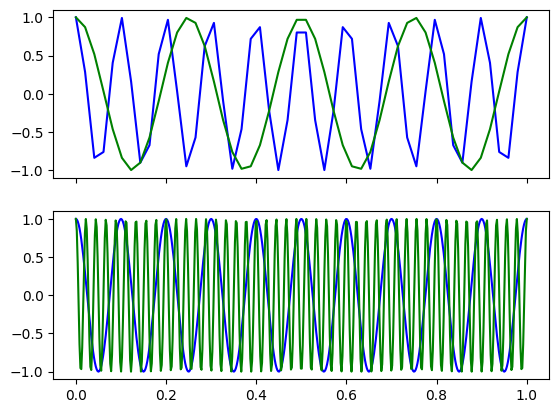

In [10]:
t = np.linspace(0, 1, 50) 
s1 = np.cos(2 * np.pi * 10 * t) 
s2 = np.cos(2 * np.pi * 45 * t) 

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, s1, color = "blue") 
ax1.plot(t, s2, color = "green") 

t2 = np.linspace(0, 1, 500)
s3 = np.cos(2*np.pi * 10 * t2) 
s4 = np.cos(2* np.pi * 45 * t2) 
ax2.plot(t2, s3, color = "blue") 
ax2.plot(t2, s4, color = "green") 


When we try to plot the desired sine wave in Hz but at a sample rate that is not as fast as the Nyquist freqency, we see a different frequency instead.

Can we predict where artefacts will be (in terms of frequency content) due to aliasing??
*Hint: look at relation between the sample rate, desired frequency, and resulting frequency*

Yes. They will appear at the absolute value of the frequency - sample rate (times nearest integer of f/fs if > 1) 

nint = nearest integer
formula for finding alias frequency:
$$ F(a) = | f - fs * nint(\frac{f}{fs}) | $$


**Let's imagine we were sampling a signal (at 44,100) that included the following frequencies (all in KHz): 22.0, 24.0, 33.0, and 40.0. We simply subtract the the "problem" or artefact frequency from sample rate:**

22.0 = # Is this a problem?  
22.1 = #Is this a problem?  
24.0 = # What about this?    
33.0 = # Or this?      
40.0 = # Or this?  

* 22k is less than 22050 (barely), so it has no issues

In [11]:
fs = 44100 
f = 22000
t = np.arange(0, 1, 1/fs) 

x = np.cos(2*np.pi * f * t) 
Audio(x, rate = fs)

So in the last two cases, we end up with perceptual artifacts in the recorded sound. This phenomenon is called aliasing (or "fake" frequencies.) 

So, how do we avoid this problem? 

The way we deal with this is to apply a low-pass filter (which allow frequencies *below* some threshold--typically the Nyquist--to pass through) to remove any of these extreme high frequencies *before* sampling to ensure we don't get artifacts. 

**This is called "anti-aliasing."** This is applied *before* the sound gets sampled through an analog to digital converter.

Since we are not using a DAW and are creating sounds "from scratch" it will be important you understand this concept.

Note that we can also get aliasing of different frequencies by sampling at lower sampling rates. It all depends on the relation between the frequencies sampled and the sampling rate.

In either case, if a sine wave is changing quickly, and the sampling rate isn't fast enough to capture it, this can result in a set of samples that look identical to a sine wave of lower frequency! 

As we saw above, the effect of this is that the higher-frequency contributions now act as impostors (i.e., aliases) of lower-frequency information. 

*IF* one recorded high frequency content intentionally, how could we play it back so that we could hear it?

-- By slowing down the sampling rate

If we have a recording sampled at 44,100 but we tell a program that the original sample rate was really 22,050 what will be the effect?

-- it will be playback at a lower "pitch" (playback at half speed, so an octave down)

If we have a recording sampled at 22,050 but we tell a player to play back at a sample rate of 44,100 what will be the effect?

-- it will playback at a higher "pitch" (playback at 2x speed so an octave up)

These are radio emissions from Saturn. The radio waves are closely related to the auroras near the poles of the planet.  

This recording has been modified so that 73 seconds corresponds to 27 minutes. Since the frequencies of these emissions are well above human hearing range, they are shifted downward by a factor of 44. 

In [ ]:
Audio('../audio/soundsSaturn.wav')

In [ ]:
Image(url="https://audiotech2images.s3.us-east-2.amazonaws.com/saturn.png", embed=True)

## Bit depth

Bit depth refers to the resolution of the information that gets stored in a sample. That is, it refers to the size (or length, or "depth") of numbers that can be used to store the amplitude information. 

A digital audio sample is measured as a string of binary numbers. Just as we can get more precision by including more and more places after a decimal point for real numbers, binary representations can get more precise by adding more bits. 

2 bits allows for 4 possibilities (0 and 1 at 2 locations); 3 bits allows for 8 possibilities; 4 bits has 16 options (below); 5 bits gives 32 options…. And it doubles each time. 

In [ ]:
# this chart shows 4 bits so up to 16 values represented 2^4
Image(filename="../images/binary-numbers-table.jpg", embed=True)

So the size of the binary representation we use to store audio information is referred to as **bit depth**, which divides the possible range of amplitudes. 

4-bit =  $2^4$ = 16 divisions of the amplitude  
8-bit =  $2^8$ = 256 divisions  
16-bit = $2^{16}$ > 65.5K divisions  
24-bit = $2^{24}$ > 16M divisions  

16 bit audio is standard for CDs. 24 bit is standard for recording in high definition audio. At 24-bit we can cover a whopping 144dB of dynamic range! 

If we look at the possibilities for how `numpy` can represent numbers, we can see:

| Numpy Type | C Type | Description |
| :-| :- | :-|
| numpy.int8 | int8_t | Byte (-128 to 127) |
| numpy.int16| int16_t| Integer (-32768 to 32767)|
|numpy.int32 | int32_t | Integer (-2147483648 to 2147483647)|
| numpy.int64 | int64_t | Integer (-9223372036854775808 to 9223372036854775807)|
| numpy.float32 | float |  Floating point up to 32-bits; around $\pm 10^{38}$ range
| numpy.float64 / numpy.float_ | double | Floating point up to 64 bit (matches python's default float precision); around $\pm 10^{308}$ range|
| numpy.complex64 | float complex | Complex number, represented by two 32-bit floats (real and imaginary components)|
| numpy.complex128 / numpy.complex_ | double complex | Note that this matches the precision of the builtin python complex.|



Because we are taking discrete measurements, the amplitude of a given sample must be rounded to the closest available value. If we had 2-bit resolution, for example, we would only have four categories for representing the amplitude (0,1,2,3; represented in binary as 00,01,10,11).

Let's look at an example:

Here is a normal 440 Hz sinusoid. The bit depth is based on the data type (np.float64 so 64 bit)

I can force this to quantize to a certain number of levels/amplitude bins. Let's try 2 bit

This is an extreme example because we are talking about a very low number of bits, but it makes it easy to see the distortion that could happen when the sampled values are rounded. 

So the more "bins" we have for amplitude, the more accurate we can be with our numeric representations. 

We get more "bins" by increasing the bit depth.

## Quantization
Think of quantization as a kind of rounding or "binning" into a fixed number of discrete categories. 

Just like with the last example, if we have a small number of bins to represent a large range of values, then we can think of quantization errors as "rounding errors." 

A **quantization error** is the difference between the actual value and the rounded or "binned" value. Quantization error typically only matters when it is relatively large.

In the above example our sine wave will start to sound more like a square wave due to this quantization error arising from the reduction of the bit depth of our signal.

We can calculate our quantization error, then plot and listen to it.

Our error when quantizing or rounding into bins get worse with lower total amplitude values or small dynamic range changes

## Quantization distortion and Dithering
Dither is a technique for dealing with something called quantization *distortion*. This tends to become a problem for signals recorded at very low amplitudes. These amplitudes are too small compared to the space between available quantization levels (defined by the bit depth). 

In other words, you get a fairly large rounding error relative to the object’s size... 

Note the large amount of quantization distortion happening for this lower amplitude signal with only 3 levels.  If we reduced the signal by half, the entire thing would be rounded to zero and the signal would disappear entirely.

### Dithering
**Dither** is typically applied when converting something from a higher resolution to a lower resolution (or bit depth), when these kinds of "rounding errors" create noticeable artifacts in the sound. Dithering is a process where one intentionally adds a very small amount of noise to the signal *before* quantization. 

You will still have noise but now it will be more random rather than "periodic"/harmonic like usual quantization noise

If we now quantize this messy signal with the noise added, the sinusoidal signal can still be extracted statistically from the noise. The noise smooths-out the transition between bit levels, eliminating the threshold problem.

When used in recording, the actual amount of noise added is very tiny and not noticable in the final mixed sound.

Depending on the dynamic range and "noisiness" of the original signal, quantization noise may not be noticeable and/or dither may not be necessary.

In [ ]:
Audio(filename="../audio/sax-phrase.wav", rate = fs)

In [ ]:
Audio(filename="../audio/TheBlackKeys_track4.wav", rate = fs)

If you are using a sound recorded in 24-bit, you have so many quantization levels for amplitude that you are practically guaranteed never to have quantization distortion. However, it can become an issue when noise "adds up" from repeated signal processing, is sometimes noticable on 16 bit recordings, especially in lower amplitude ranges (~ -60dBFS).

## Amplitude and loudness

(this text modified from [this site](https://music.arts.uci.edu/dobrian/digitalaudio.htm))

The relationship between the objectively measured amplitude of a sound and our subjective impression of its loudness is complicated. 

Our sense of the relative loudness of two sounds is related to the ratio of their intensities, rather than the mathematical difference in their intensities. 

For example, the relationship between a sound of amplitude 1 and a sound of amplitude 0.5 is the same to us as the relationship between a sound of amplitude 0.25 and a sound of amplitude 0.125. The subtractive difference between amplitudes is 0.5 in the first case and 0.125 in the second case, but what concerns us perceptually is the ratio, which is 2:1 in both cases.

Does a sound with twice as great an amplitude sound twice as loud to us? 

In general, the answer is "no". Our subjective sense of "loudness" is not directly proportional to amplitude. 

The softest sound we can hear has about one millionth the amplitude (or intensity) of the loudest sound we can bear. Rather than discuss amplitude using such a wide range of numbers from 0 to 1,000,000, it is more common to compare amplitudes on a logarithmic scale.

**The ratio between two amplitudes is commonly discussed in terms of decibels (abbreviated dB).** A level expressed in terms of decibels is a statement of a ratio relationship between two values—not an absolute measurement. If we consider one amplitude as a reference which we call A0, then the relative amplitude of another sound in decibels can be calculated with the equation:

$20 × log_{10}(a\ /\ a0)$

Note: 1 decibel is the just noticeable difference (JND) in sound intensity for the normal human ear.

## File types
OK, this brings us to file types and the storing of audio information. So if we thought about the uncompressed sound stored on a CD, for example, there are 16 bits of information for every sample *per* channel! 

So assuming two channels, and a sample rate of 44,100 that's 44100 * 16 * 2 = 1,411,200 bits or ~1411 Kbits of data per second. The amount of data per second is known as the **bit rate.**

Computers used to be a lot slower and had less space. So in order to store it or transfer over internet, audio files needed to get smaller. So different mathematical algorithms appeared for compressing files. Depending on the method, it was translated into something called a **codec**. 

A full quality uncompressed file like a .wav file would have a codec applied and result in a smaller file, like an MP3.

MP3s for example, at highest quality have a bit rate of approximately 320 Kbits/s. 

(Codec stands for compression/decompression)

OK, so what are some ways we could reduce the amount of information in the original file?

1) Adjust sample rate. In order to scale back the size of the information per second, we would have to cut the sample rate by an order of around four. 

However, cutting sample rate we run into a host of problems, especially if we cut it by that much. (We'll return to topic of downsampling...) 

2) Reduce the bit depth. However, even reducing the bit depth to 8 would only get us to about 705 Kbits/s. So, what other options are there?

Recall our hearing range charts. Not many people can hear below around 50-60Hz and our hearing drops sharply above 15-16KHz, so one compression method simply eliminates any stored information that falls below 50Hz and above 15Khz, for example.

Most compression formats use fancy psychoacoustic models to determine which aspects of a sound we are unlikely to hear (for any number of reasons) and *throw away that information* in order to save space and/or transmission time. 

There are two types of compression: *Lossless* and *Lossy*. The above two examples illustrate what's known as "lossy" compression because aspects of the original file are genuinely thrown away. 

Common lossy file types include: MP3, ACC, and OGG. 

Lossless, on the other hand, provides a kind of code or shortcut for storing data; for example, this type of code might say there are 500 zeros in a row, instead of physically storing all those zeros. The most common type of lossless file is FLAC (stands for Free Lossless Audio Codec).